In [1]:
import sys
!{sys.executable} -m pip install numpy pandas matplotlib scikit-learn | grep -v 'already satisfied'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

Defaulting to user installation because normal site-packages is not writeable
distutils: /home/yc96/.local/lib/python3.9/site-packages
sysconfig: /home/yc96/.local/lib64/python3.9/site-packages
user = True
home = None
root = None
prefix = None


In [4]:
# Read in the dataset
df = pd.read_csv("/cs/studres/ID5059/Coursework/Coursework-2/data/train.csv")
# Clear the maximum number of columns to be displayed, so that all will be visible.
pd.set_option('display.max_columns', None)
df_safe = df.copy()

# df dimensions = NxM
N = df.shape[0]
M = df.shape[1]

# Creating Missing Data:

In [5]:

 # function to randomly create 10-40% missing data in 70% of the relevant columns
 def remover(df):

    remove_vals = df.copy();
    num_columns = len(remove_vals.columns);
    np.random.seed(120)
    rem_columns = round(num_columns * 0.7, 0)
    random_arr = []
    count = 0
    while count < rem_columns :
        r = np.random.randint(1, num_columns -1);
        if r not in random_arr:
            count +=1;
            random_arr.append(r);

    count = 0;
    for column in remove_vals:
        if count in random_arr:
            random_perc = np.random.uniform(0.1, 0.4);
        #print("column: ", column, " precentage: ", random_perc);
            cur_mask = np.random.choice([True, False], size= len(remove_vals[column]), p=[random_perc,1 - random_perc]);
            remove_vals[column] = remove_vals[column].mask(cur_mask);
        count+=1;
    return remove_vals

 # dataframe with missing values   
df_del = remover(df)

# Imputing the Data

### Class Mean Imputer
Imputing the feature mean corresponding to the instance's class (0 or 1):

In [38]:
from sklearn.impute import SimpleImputer

def class_mean_imputer(df):
    # compute the mean for each feature and class label
    class_labels = df['Class']
    class_means = []
    for label in np.unique(class_labels):
        class_means.append(df[class_labels == label].mean())

    # impute missing values using class means
    df_class_mean_imputed = SimpleImputer(strategy='mean').fit_transform(df)
    for i in range(len(df)):
        for j in range(len(df.columns)):
            if np.isnan(df_class_mean_imputed[i, j]):
                df_class_mean_imputed[i, j] = class_means[class_labels[i]][j]

    class_mean_imputed = pd.DataFrame(df_class_mean_imputed, index = df.index, columns=df.columns)
    return class_mean_imputed

df_class_mean_imputed = class_mean_imputer(df_del)


### Iterative Imputers

Imputing using an iterative imputer with the default estimator, a Bayesian Ridge:

In [39]:
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

def iterative_imputer_BR(df):
    pipeline = Pipeline([('imputer', IterativeImputer(max_iter=20, random_state=0))]) 
    df_II_imputed = pd.DataFrame(pipeline.fit_transform(df_del), columns = df.columns)
    return df_II_imputed

df_II_BR_imputed = iterative_imputer_BR(df_del)

/home/yc96/.local/lib/python3.9/site-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Imputing using an iterative imputer with a Random Forest Regressor as the estimator:

In [8]:

from sklearn.ensemble import RandomForestRegressor

def iterative_imputer_RF(df):
    rf_regressor = RandomForestRegressor(n_estimators=4, max_depth=10, bootstrap=True, 
                                            max_samples=0.5, n_jobs=2, random_state=0) # tuned hyperparameters
    pipeline = Pipeline([('imputer', IterativeImputer(estimator=rf_regressor, 
                              missing_values=np.nan, 
                              random_state=123))]) 
    df_II_imputed = pd.DataFrame(pipeline.fit_transform(df_del), columns = df.columns)
    return df_II_imputed

df_II_RF_imputed = iterative_imputer_RF(df_del)


# Imputation Methods Comparison

In [40]:
# Obtain the columns for which there was missing data that has been imputed (other columns do not need to be analysed)
df_diff = df.compare(df_del)
relevant_cols = df_diff.columns.get_level_values(0).unique().tolist()

# defining functions to compare the errors in our imputation methods:

def get_errors(df,df_imputed):
    Es = (df[relevant_cols]-df_imputed[relevant_cols])
    MSEs = (Es**2).mean(0)
    RMSEs = MSEs**0.5
    RMSEs_perc = 100*RMSEs/abs(np.mean(df[relevant_cols]))
    MAEs = abs(Es).sum() / N
    MAEs_perc = 100*MAEs/abs(np.mean(df[relevant_cols]))
    errors = pd.concat([MSEs,RMSEs,RMSEs_perc,MAEs,MAEs_perc], axis=1)
    errors.columns = ['MSE','RMSE','RMSE %','MAE','MAE %']
    return errors.transpose()

def get_mean_RMSE_perc(df,df_imputed):
    Es = (df[relevant_cols]-df_imputed[relevant_cols])
    MSEs = (Es**2).mean(0)
    RMSEs = MSEs**0.5
    RMSEs_perc = 100*RMSEs/abs(np.mean(df[relevant_cols]))
    mean_RMSEs_perc = np.mean(RMSEs_perc)
    return mean_RMSEs_perc

def get_mean_MAE_perc(df,df_imputed):
    Es = (df[relevant_cols]-df_imputed[relevant_cols])
    MAEs = abs(Es).sum() / N
    MAEs_perc = 100*MAEs/abs(np.mean(df[relevant_cols]))
    mean_MAEs_perc = np.mean(MAEs_perc)
    return mean_MAEs_perc

Now we will compare the errors for each of our imputation methods using plots to visualize the differences:

In [41]:
# Errors in class mean imputer:
get_errors(df,df_class_mean_imputed)

,Time,V1,V2,V4,V5,V6,V7,V9,V10,V12,V13,V14,V15,V16,V17,V18,V19,V20,V23,V24,V25,V28
MSE,2.572861e+08,0.553432,0.306578,0.627574,0.388775,0.257082,0.197933,0.413829,0.253215,0.220610,0.129953,0.159659,0.161828,0.192482,0.074333,0.226033,0.152788,0.048201,0.017322,0.084298,0.063838,0.004108
RMSE,1.604014e+04,0.743930,0.553695,0.792196,0.623518,0.507032,0.444896,0.643295,0.503205,0.469692,0.360490,0.399574,0.402278,0.438728,0.272641,0.475430,0.390881,0.219546,0.131613,0.290341,0.252661,0.064093
RMSE %,5.657207e+02,0.026238,0.019528,0.027940,0.021991,0.017883,0.015691,0.022688,0.017748,0.016566,0.012714,0.014093,0.014188,0.015474,0.009616,0.016768,0.013786,0.007743,0.004642,0.010240,0.008911,0.002260
MAE,7.688663e+03,0.329005,0.187247,0.395396,0.261046,0.149065,0.172446,0.300598,0.219694,0.164320,0.097473,0.140674,0.144736,0.190518,0.076563,0.219762,0.159339,0.063292,0.028064,0.108710,0.123579,0.010247
MAE %,2.711719e+02,0.011604,0.006604,0.013945,0.009207,0.005257,0.006082,0.010602,0.007748,0.005795,0.003438,0.004961,0.005105,0.006719,0.002700,0.007751,0.005620,0.002232,0.000990,0.003834,0.004359,0.000361


In [42]:
# Errors in iterative imputer using a Bayesian Ridge:
get_errors(df,df_II_BR_imputed)

,Time,V1,V2,V4,V5,V6,V7,V9,V10,V12,V13,V14,V15,V16,V17,V18,V19,V20,V23,V24,V25,V28
MSE,2.087104e+07,0.389087,0.101381,0.614505,0.189242,0.204656,0.123539,0.403240,0.215868,0.198996,0.410044,0.138737,0.168908,0.175012,0.086038,0.244048,0.167814,0.028801,0.019604,0.096268,0.057264,0.005074
RMSE,4.568483e+03,0.623768,0.318404,0.783904,0.435020,0.452389,0.351482,0.635012,0.464615,0.446090,0.640346,0.372474,0.410984,0.418344,0.293323,0.494012,0.409651,0.169707,0.140014,0.310271,0.239298,0.071230
RMSE %,1.611261e+02,0.022000,0.011230,0.027648,0.015343,0.015955,0.012396,0.022396,0.016387,0.015733,0.022584,0.013137,0.014495,0.014755,0.010345,0.017423,0.014448,0.005985,0.004938,0.010943,0.008440,0.002512
MAE,2.138489e+03,0.183774,0.089706,0.330827,0.144013,0.112756,0.103118,0.260669,0.174613,0.128976,0.102861,0.115699,0.139495,0.159461,0.056901,0.202828,0.153402,0.044290,0.026000,0.111365,0.105293,0.010081
MAE %,7.542251e+01,0.006482,0.003164,0.011668,0.005079,0.003977,0.003637,0.009194,0.006158,0.004549,0.003628,0.004081,0.004920,0.005624,0.002007,0.007154,0.005410,0.001562,0.000917,0.003928,0.003714,0.000356


In [43]:
# Errors in iterative imputer using a Random Forest regressor:
get_errors(df,df_II_RF_imputed)

,Time,V1,V2,V4,V5,V6,V7,V9,V10,V12,V13,V14,V15,V16,V17,V18,V19,V20,V23,V24,V25,V28
MSE,172.723427,0.081771,0.058539,0.234457,0.088176,0.050944,0.047608,0.123084,0.096901,0.049017,0.053527,0.053881,0.082704,0.077902,0.031392,0.098449,0.096367,0.022198,0.012726,0.032077,0.024369,0.002677
RMSE,13.142429,0.285957,0.241949,0.484208,0.296945,0.225707,0.218193,0.350834,0.311290,0.221397,0.231360,0.232122,0.287584,0.279109,0.177177,0.313766,0.310430,0.148991,0.112811,0.179099,0.156105,0.051741
RMSE %,0.463521,0.010085,0.008533,0.017078,0.010473,0.007960,0.007695,0.012374,0.010979,0.007808,0.008160,0.008187,0.010143,0.009844,0.006249,0.011066,0.010949,0.005255,0.003979,0.006317,0.005506,0.001825
MAE,6.181551,0.083878,0.065735,0.188190,0.100796,0.056618,0.062541,0.140573,0.116961,0.069490,0.057907,0.078409,0.096472,0.104346,0.046502,0.131138,0.119034,0.042025,0.020171,0.058276,0.063945,0.007381
MAE %,0.218017,0.002958,0.002318,0.006637,0.003555,0.001997,0.002206,0.004958,0.004125,0.002451,0.002042,0.002765,0.003402,0.003680,0.001640,0.004625,0.004198,0.001482,0.000711,0.002055,0.002255,0.000260


In [50]:
mean_RMSE_percs

[25.72897138742364, 7.33750912150175, 0.029272041336478163]

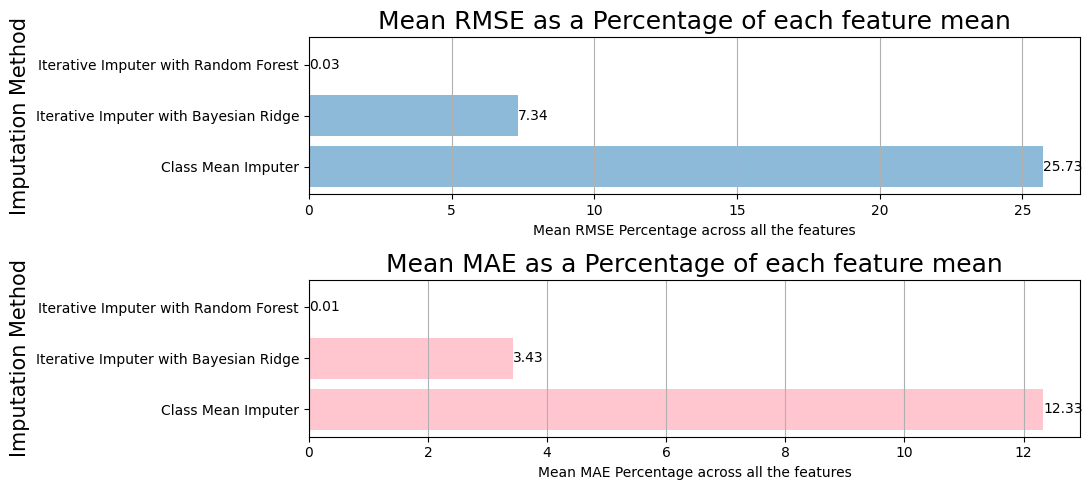

In [55]:
# Bar Charts to compare the RMSE and MAE error across all features

imputed = [df_class_mean_imputed, df_II_BR_imputed, df_II_RF_imputed]
mean_RMSE_percs = [get_mean_RMSE_perc(df, df_imputed) for df_imputed in imputed]
mean_MAE_percs = [get_mean_MAE_perc(df, df_imputed) for df_imputed in imputed]

positions = np.arange(3)
labels = ['Class Mean Imputer', 'Iterative Imputer with Bayesian Ridge', 'Iterative Imputer with Random Forest']

fig, axes = plt.subplots(2,1,figsize=(11,5))
ax1,ax2 = axes.flatten()

# RMSE Bar Plot
bc1 = ax1.barh(width = mean_RMSE_percs, y=positions, align='center', alpha=0.5, capsize=10, label='Mean RMSE %')

ax1.set_title('Mean RMSE as a Percentage of each feature mean', fontsize=18)
ax1.set_xlabel('Mean RMSE Percentage across all the features')
ax1.set_ylabel('Imputation Method', fontsize=15)
ax1.xaxis.grid(True)
ax1.set_yticks(positions)
ax1.set_yticklabels(labels, fontsize=10)

# Add value labels to the bars 
for bar in bc1:     
    value = bar.get_width()
    ax1.text(value, bar.get_y() + bar.get_height() / 2, f'{value:.2f}',
            ha='left', va='center')

# MAE Bar Plot
bc2 = ax2.barh(width = mean_MAE_percs, y=positions, align='center', color='pink', alpha=0.9, capsize=10)

ax2.set_title('Mean MAE as a Percentage of each feature mean', fontsize=18)
ax2.set_xlabel('Mean MAE Percentage across all the features')
ax2.set_ylabel('Imputation Method', fontsize=15)
ax2.xaxis.grid(True)
ax2.set_yticks(positions)
ax2.set_yticklabels(labels, fontsize=10)

# Add value labels to the bars 
for bar in bc2:     
    value = bar.get_width()
    ax2.text(value, bar.get_y() + bar.get_height() / 2, f'{value:.2f}',
            ha='left', va='center')

fig.tight_layout()
plt.show()

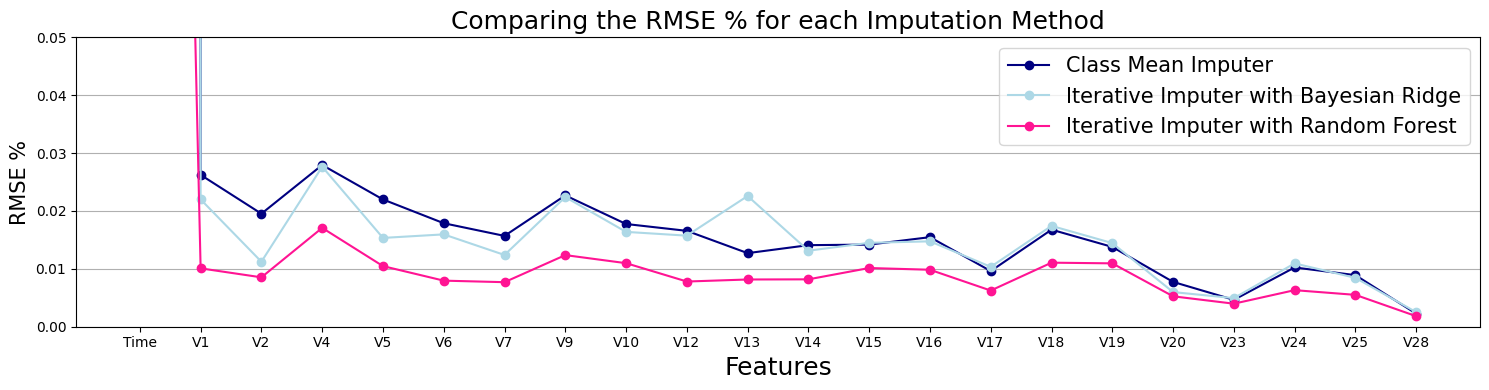

In [54]:
# Plotting the RMSE % of each feature to compare the 3 imputation methods

class_mean_errors = get_errors(df,df_class_mean_imputed).loc['RMSE %']
bayesian_ridge_errors = get_errors(df,df_II_BR_imputed).loc['RMSE %']
random_forest_errors = get_errors(df,df_II_RF_imputed).loc['RMSE %']

fig, ax = plt.subplots(1,1,figsize=(15,4))
ax.plot(class_mean_errors, label='Class Mean Imputer', marker='o', color='navy')
ax.plot(bayesian_ridge_errors, label='Iterative Imputer with Bayesian Ridge', marker='o', color='lightblue')
ax.plot(random_forest_errors, label='Iterative Imputer with Random Forest', marker='o', color='deeppink')
ax.set_ylim(0,0.05) # otherwise the large error in 'Time' hides the results
ax.set_title('Comparing the RMSE % for each Imputation Method', fontsize=18)
ax.set_xlabel('Features',fontsize=18)
ax.set_ylabel('RMSE %',fontsize=15)
ax.yaxis.grid(True)
ax.legend(fontsize=15)
fig.tight_layout()
plt.show()


The line graph above shows the error for the random forest iterative imputer has much smaller errors across all features.
So, this will be our chosen imputation method.

In [48]:
# Storing the imputed data from the Iterative Imputer with a random forest regressor method
df_imputed = df_II_RF_imputed

# Exploring our final Imputed Data

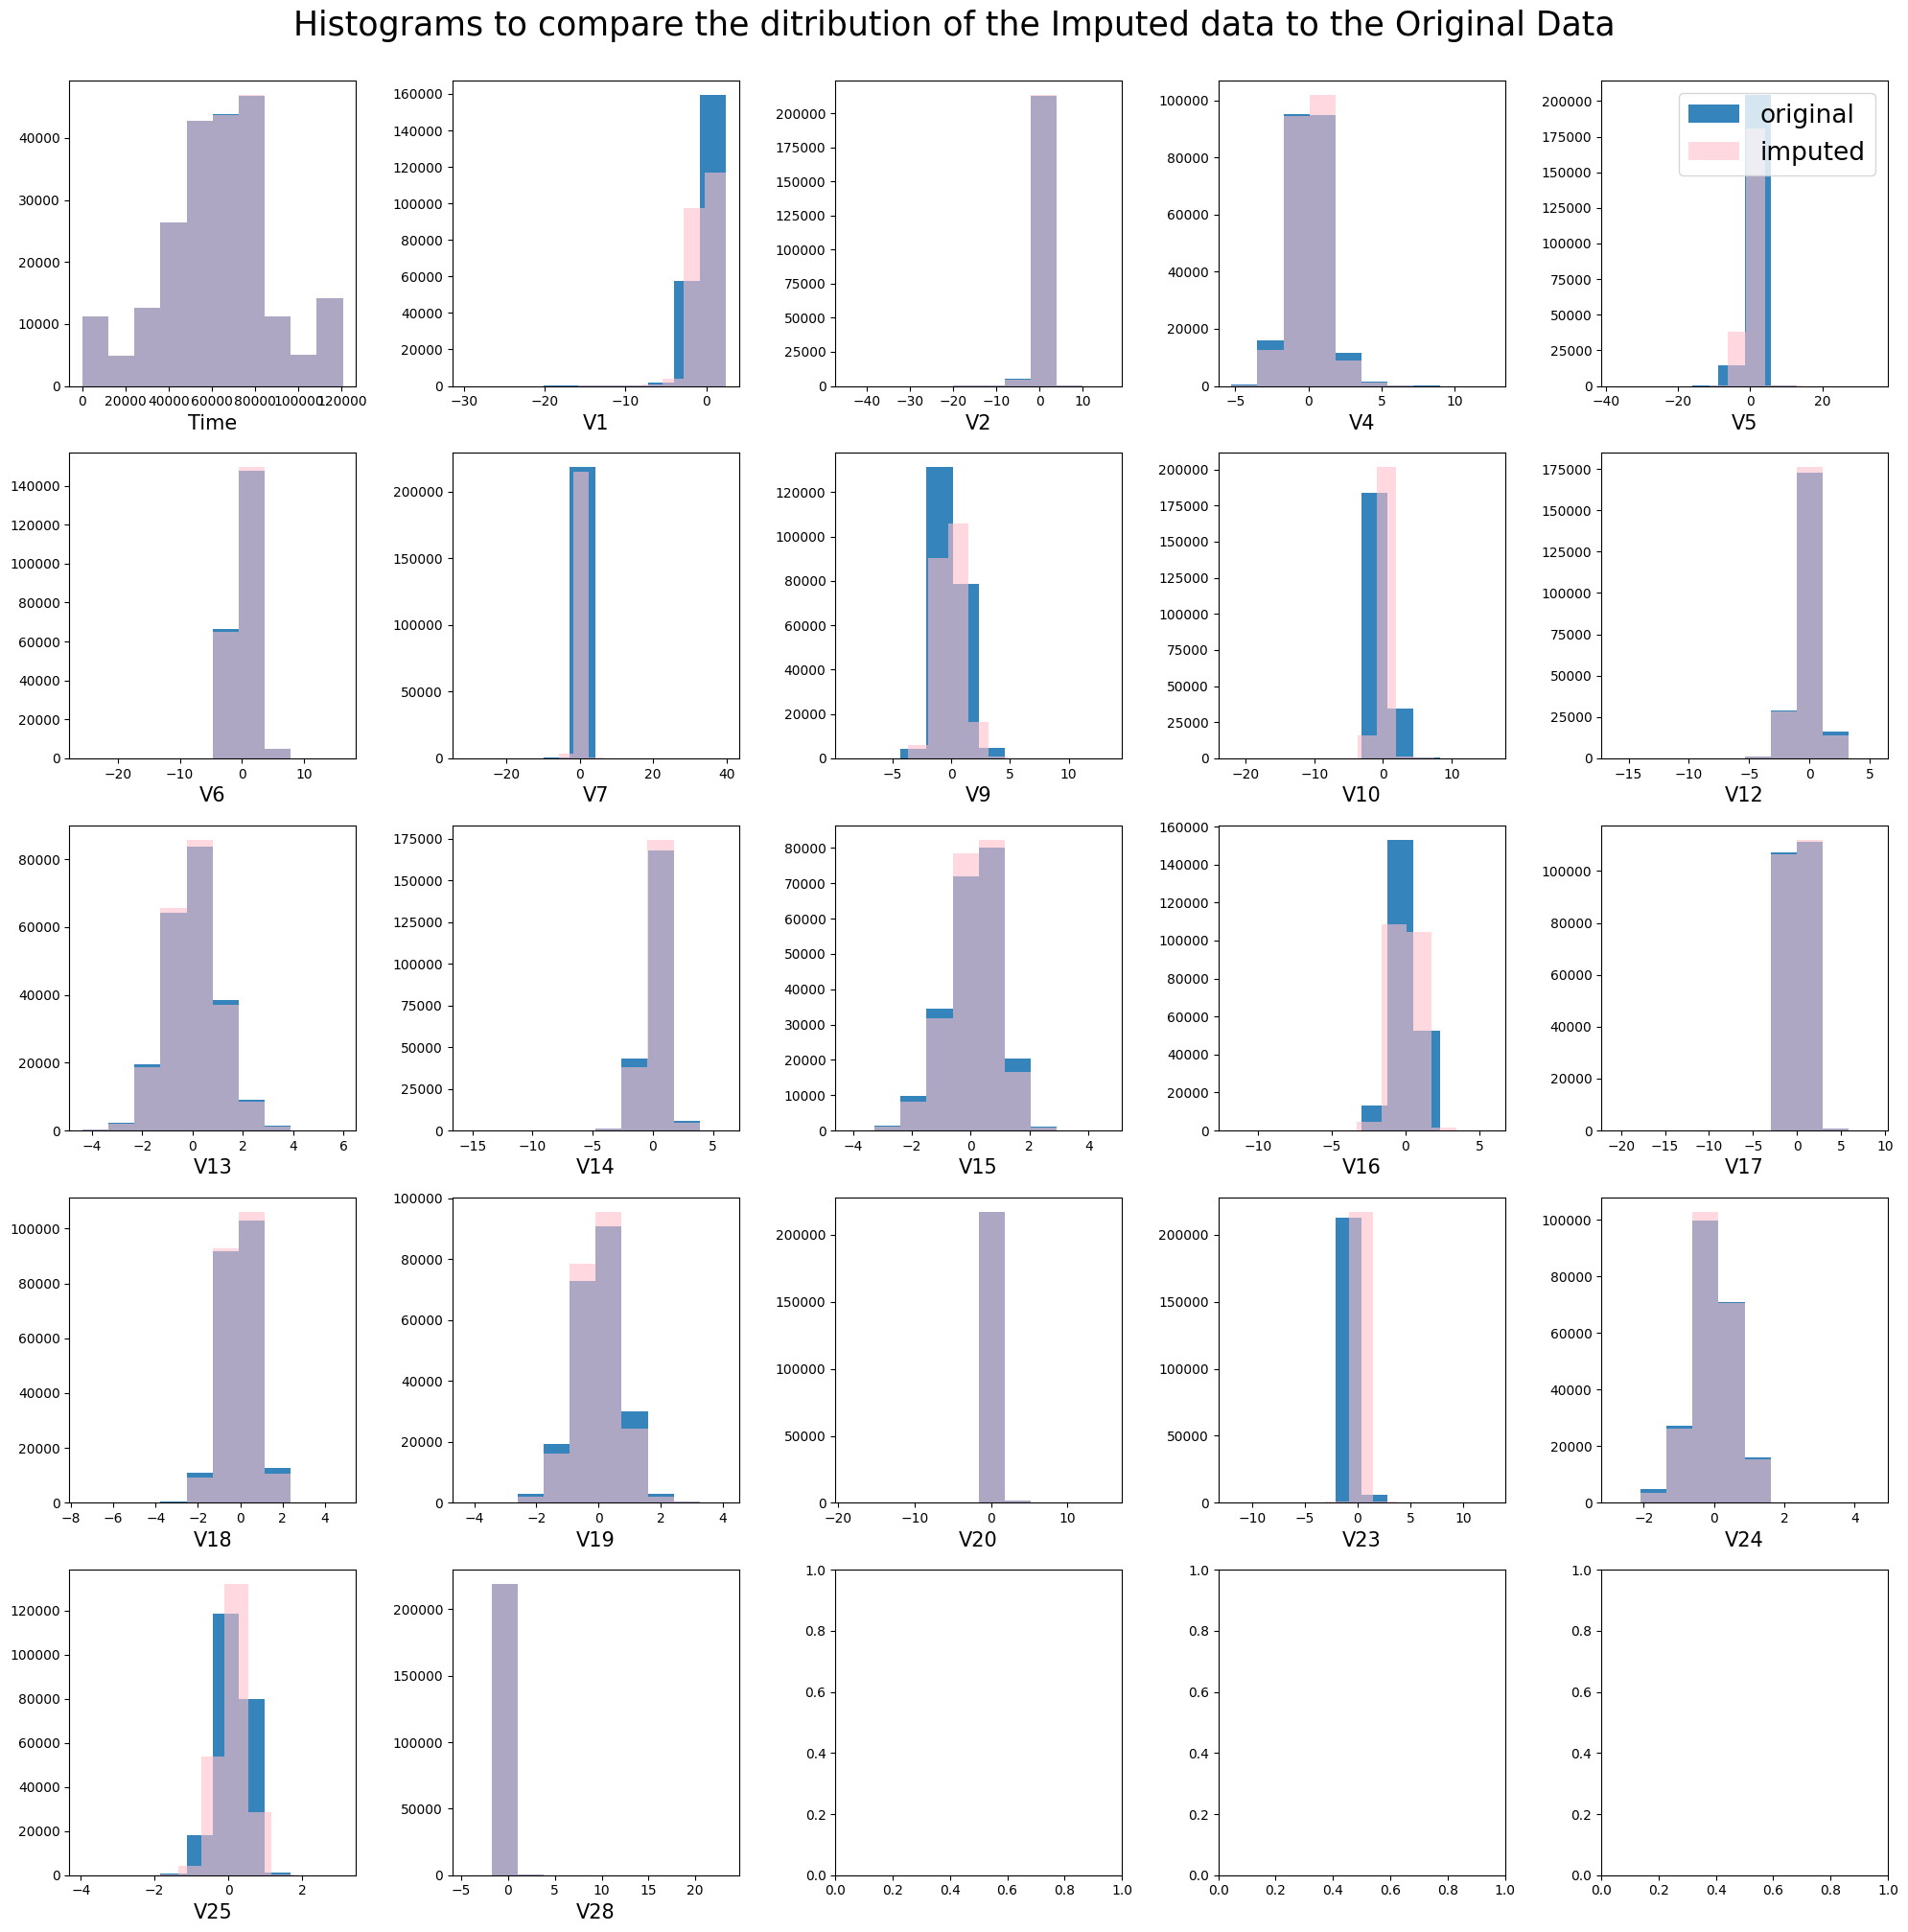

In [49]:
# Histograms to compare the ditribution of the Imputed data to the Original Data
fig, axes = plt.subplots(5,5, figsize=(20,20))
axes = axes.flatten()

for i in range(len(relevant_cols)):
    axes[i].hist(df[relevant_cols[i]], bins=10, alpha=0.9, label='original')
    axes[i].hist(df_imputed[relevant_cols[i]], bins=10, alpha=0.6, label='imputed', color='pink')
    axes[i].set_xlabel(f'{relevant_cols[i]}', fontsize=15)
plt.suptitle('Histograms to compare the ditribution of the Imputed data to the Original Data', fontsize=25, y=1.005)

fig.tight_layout()
axes[4].legend(loc = 'upper right', fontsize=19)
plt.show()

### Error Scatter Plots

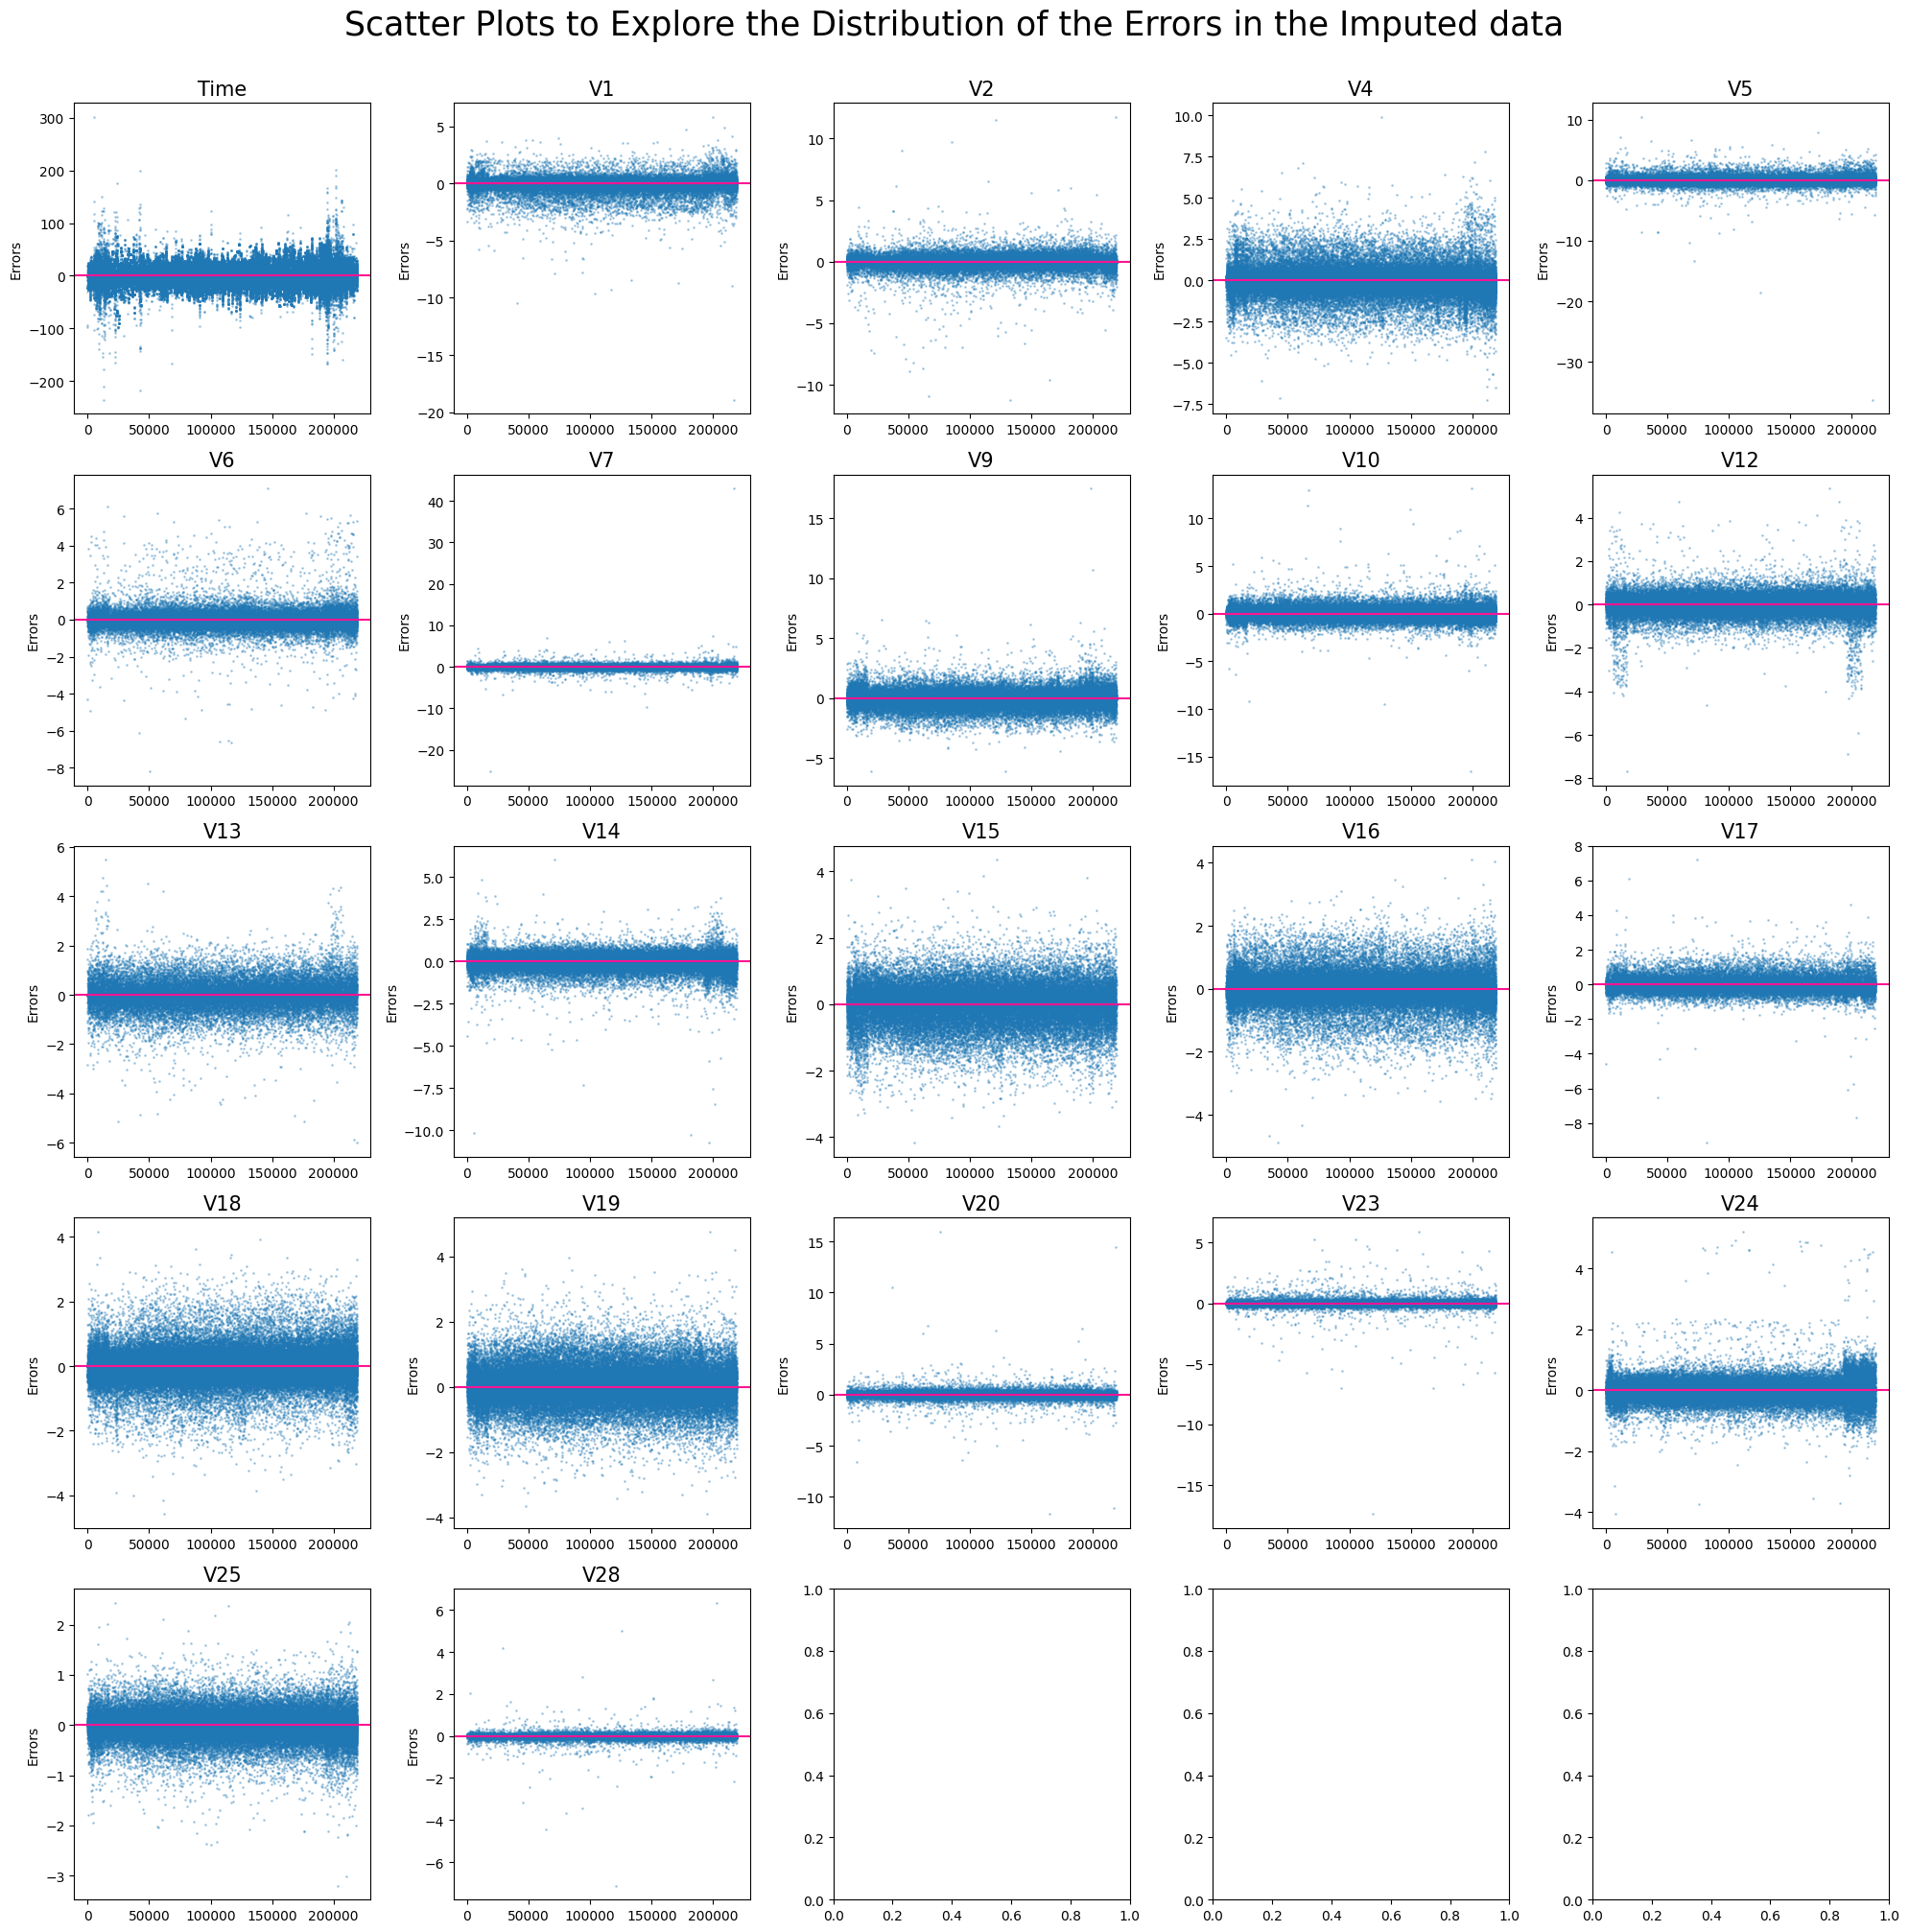

In [28]:
# Obtain the errors in each values of our imputed data
Es = df[relevant_cols]-df_imputed[relevant_cols]

# Scatter Plots to Explore the Distribution of the Errors in the Imputed data
fig, axes = plt.subplots(5,5, figsize=(20,20))
axes = axes.flatten()

for i in range(len(relevant_cols)):
    axes[i].scatter( list(range(N)),Es[relevant_cols[i]], s=1, alpha=0.3)
    axes[i].axhline(y=0, color='deeppink') # zero error line

    axes[i].set_title(f'{relevant_cols[i]}', fontsize=15)
    axes[i].set_ylabel('Errors')

plt.suptitle('Scatter Plots to Explore the Distribution of the Errors in the Imputed data',y=1.005, fontsize=25)
fig.tight_layout()
plt.show()

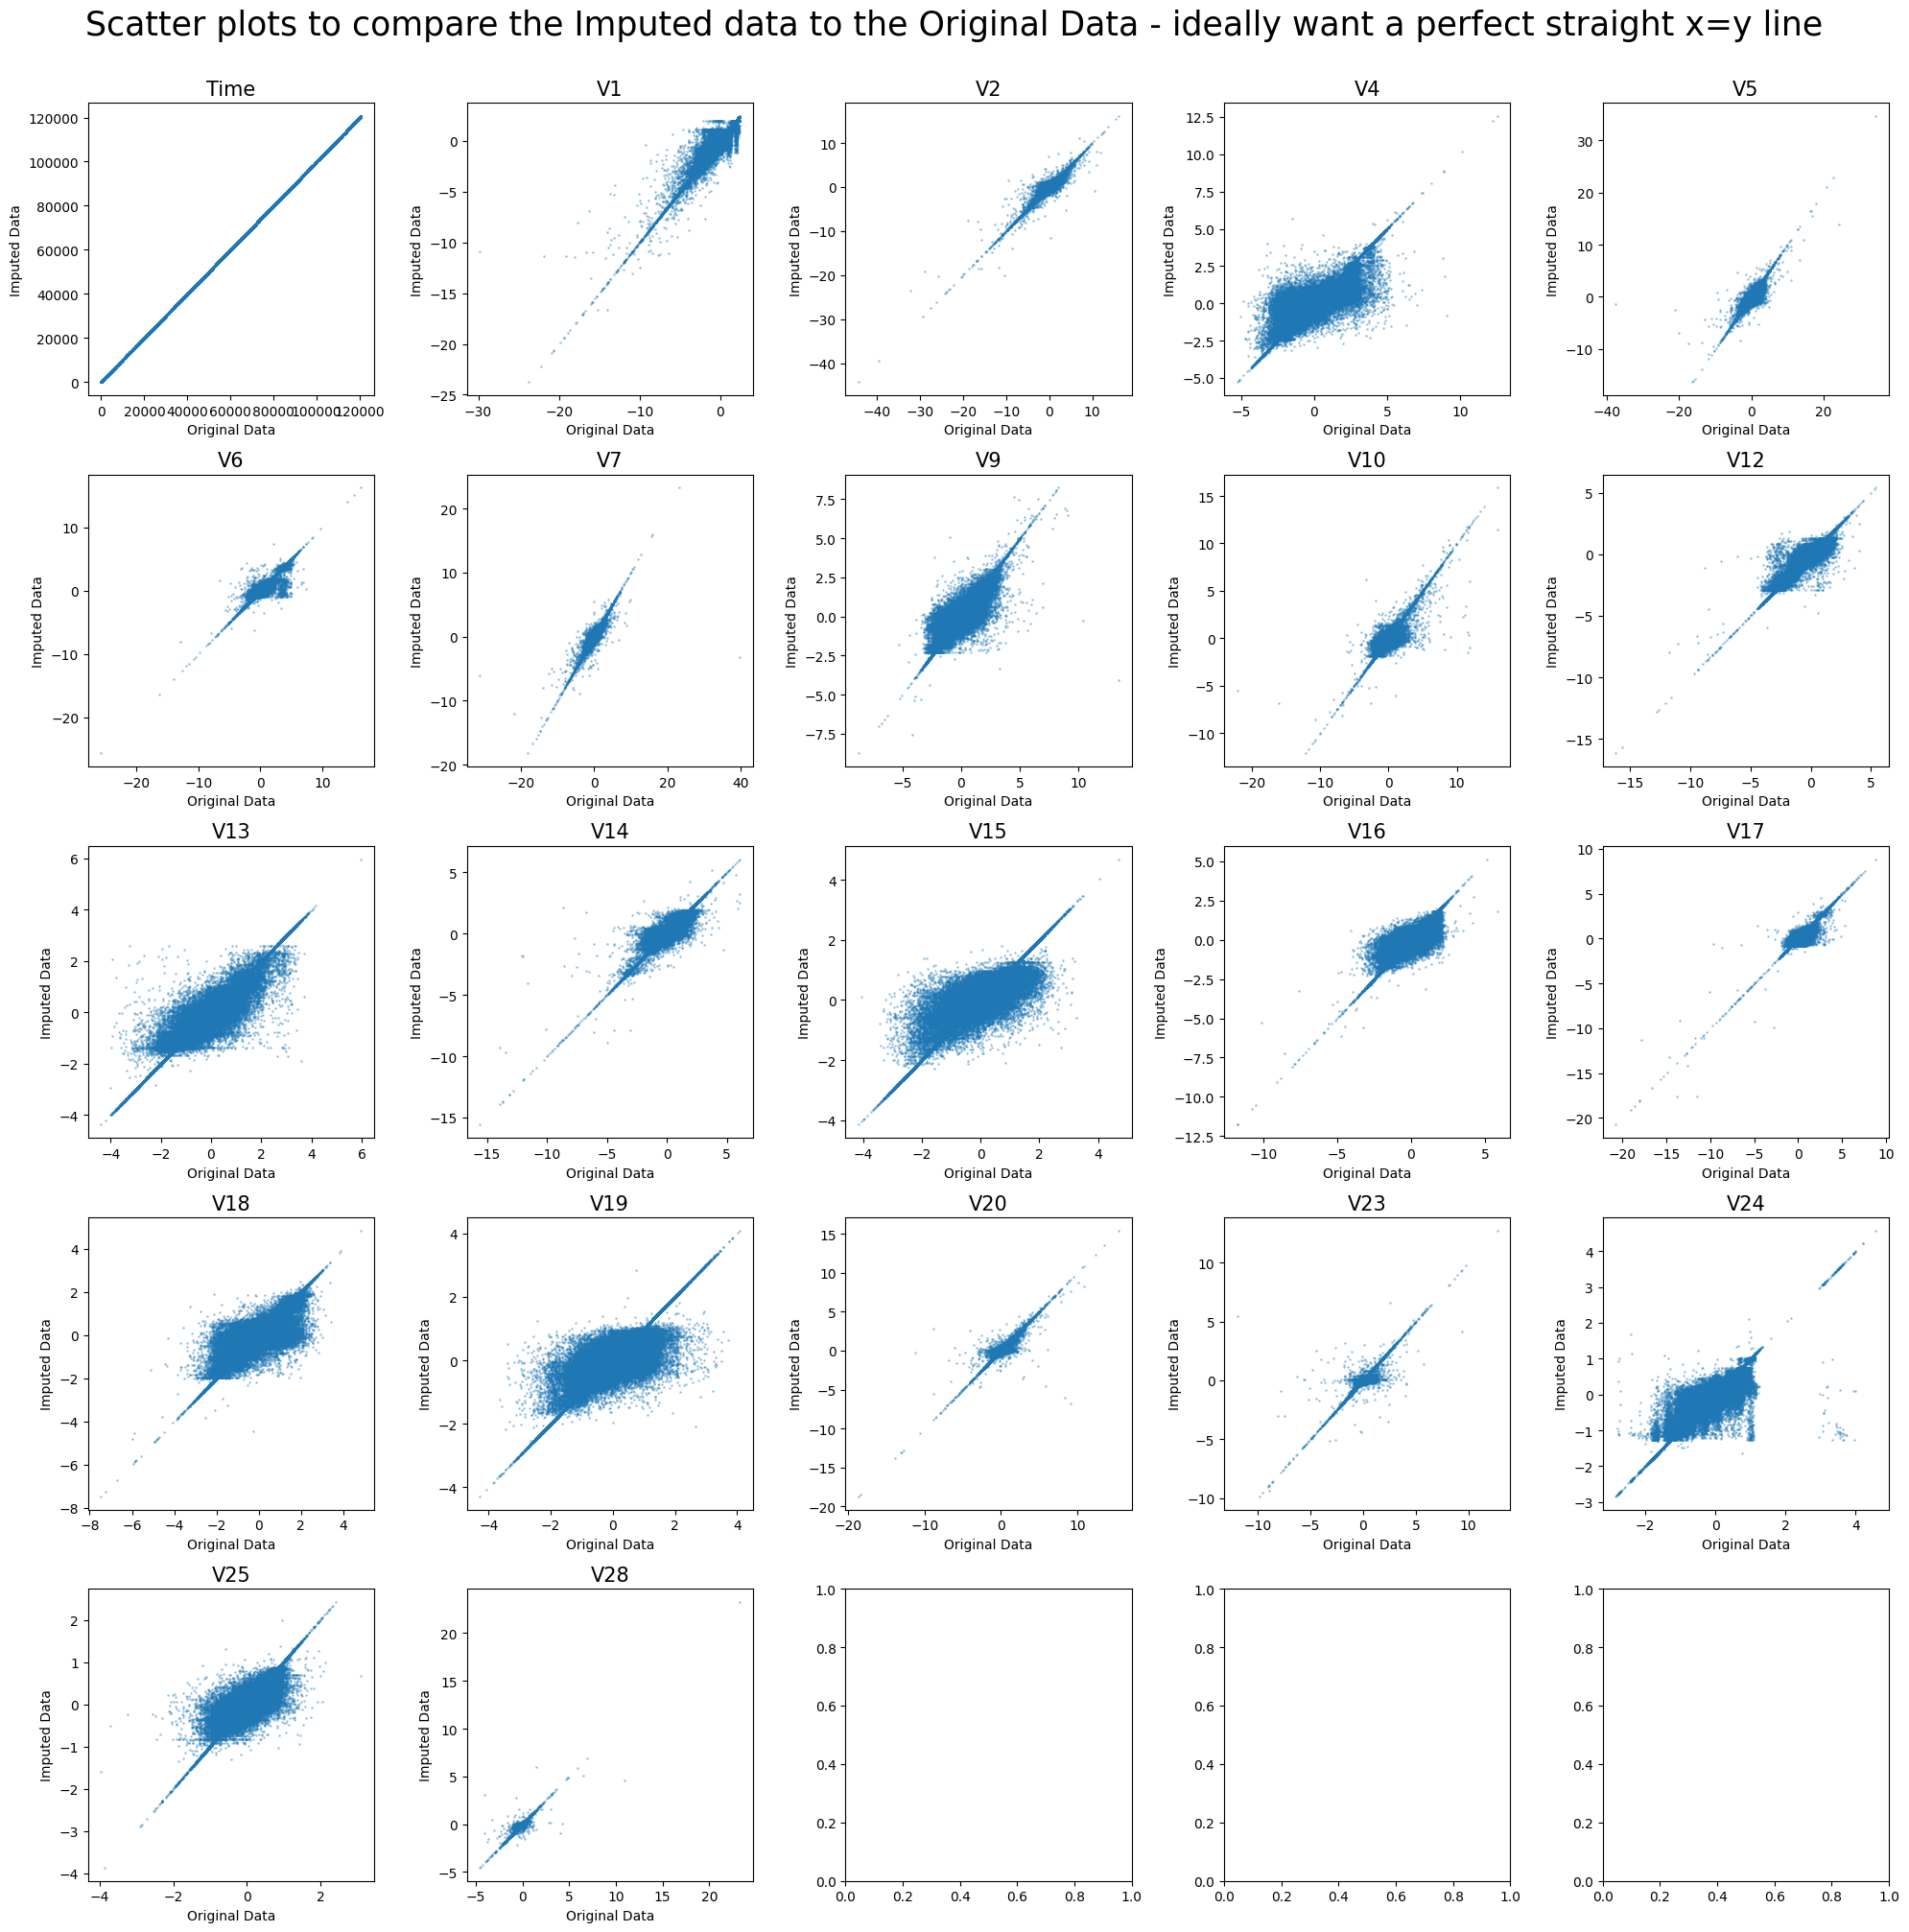

In [29]:
# Scatter plots to compare the Imputed data to the Original Data - ideally want a perfect straight x=y line
fig, axes = plt.subplots(5,5, figsize=(20,20))
axes = axes.flatten()

for i in range(len(relevant_cols)):
    axes[i].scatter(df[relevant_cols[i]], df_imputed[relevant_cols[i]], s=1, alpha=0.3)
    axes[i].set_title(f'{relevant_cols[i]}', fontsize=15)
    axes[i].set_xlabel('Original Data')
    axes[i].set_ylabel('Imputed Data')
    axes[i].plot()

plt.suptitle('Scatter plots to compare the Imputed data to the Original Data - ideally want a perfect straight x=y line', fontsize=25, y=1.005)
fig.tight_layout()
plt.show()
